In [1]:
import numpy as np
import networkx as nx
import json
from networkx.readwrite import json_graph
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
import os
import sys
import pickle as pkl
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
from collections import Counter

In [2]:
def load_data(dataset_str):
    """
    Loads input data from gcn/data directory
    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.
    All objects above must be saved using python pickle module.
    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("/data/{}_gcn/ind.{}.{}".format(dataset_str, dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("/data/{}_gcn/ind.{}.test.index".format(dataset_str, dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, labels

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [43]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [ ]:
cora, cora_f, cora_ytrain, cora_yval, cora_ytest, cora_trainm, cora_valm, cora_tmask, cora_l = load_data("cora")
cora_np = cora.toarray()
cora_dict = {i: np.nonzero(cora_np[i])[0].tolist() for i in range(cora_np.shape[0])}
cora_nx = nx.Graph(cora_dict)

In [51]:
def graph_report(nx_graph, name=None):
    print("==== {} Report ====".format(name or "Untitled Graph"))
    print("Number of nodes: {:,} nodes".format(nx_graph.number_of_nodes()))
    print("Number of edges: {:,} edges".format(nx_graph.number_of_edges()))
    degs = nx_graph.degree().values()
    print("Average degree: {:.3f} edges / node".format(np.mean(degs)))
    print("Maximum degree: {:,} edges".format(np.max(degs)))
    print("Minimum degree: {:,} edges".format(np.min(degs)))
    print("Gini coefficient: {:.3f}".format(gini(np.array(degs, dtype=float))))
    print("Number of connected components: {} components".format(nx.number_connected_components(nx_graph)))
    print("Degree assortivity: {:.3f}".format(nx.assortativity.degree_assortativity_coefficient(nx_graph)))

In [52]:
graph_report(cora_nx, name="Cora")

==== Cora Report ====
Number of nodes: 2,708 nodes
Number of edges: 5,278 edges
Average degree: 3.898 edges / node
Maximum degree: 168 edges
Minimum degree: 1 edges
Gini coefficient: 0.405
Number of connected components: 78 components
Degree assortivity: -0.066


In [ ]:
nx.connected_component_subgraphs

In [99]:
def laplacian_spectrum(gnx, name=None):
    print("==== {} Report ====".format(name or "Untitled Graph"))
    lspec = nx.spectrum.laplacian_spectrum(gnx)
    print("Spectrum gap: {}".format(lspec[-1] - lspec[-2]))
    # Plot
    sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Computer Modern'})
    sns.set(font_scale=1.2) 
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_title("Laplacian Eigenvalues of {}".format(name), fontsize=15)
    ax.set_xlabel("Index", fontsize=15)
    ax.set_ylabel("Real", fontsize=15)
    ax.set_xscale("linear")
    sns.lineplot(x=range(gnx.number_of_nodes()), y=lspec)
    plt.savefig("lapspec_{}.pdf".format(name))

==== Cora Report ====
Spectrum gap: 89.9669732257


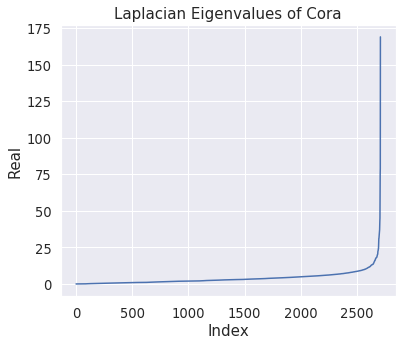

In [100]:
laplacian_spectrum(cora_nx, "Cora")

In [123]:
def plot_degree_dist(nxg, name=None):
    print("==== {} Report ====".format(name or "Untitled Graph"))
    degs = nxg.degree().values()
    degs = Counter(degs)
    xdata = sorted(degs.keys())
    ydata = [degs[i] for i in xdata]
    # Plot
    sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Computer Modern'})
    sns.set(font_scale=1.2) 
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_title("Degree Distribution of {}".format(name), fontsize=15)
    ax.set_xlabel("Log-Degree", fontsize=15)
    ax.set_ylabel("Log-Count", fontsize=15)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax = sns.scatterplot(x=xdata, y=ydata)
    plt.savefig("degree_{}.pdf".format(name))

==== Cora Report ====


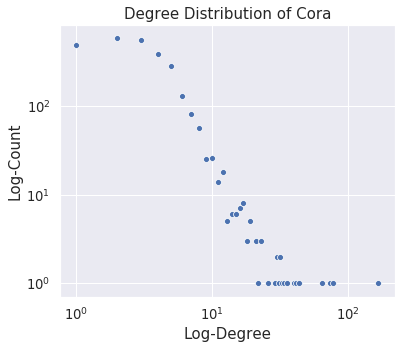

In [124]:
plot_degree_dist(cora_nx, "Cora")

In [125]:
nx.density(cora_nx)

0.0014399999126942077

In [126]:
er_cora = nx.erdos_renyi_graph(cora_nx.number_of_nodes(), nx.density(cora_nx))

In [127]:
er_cora.size()

5406

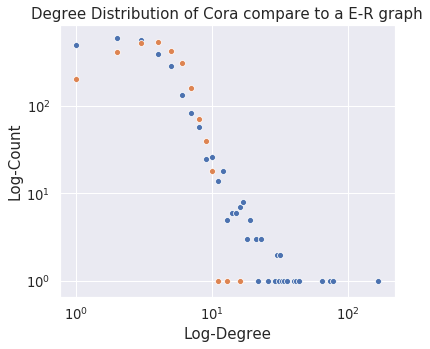

In [129]:
degs = cora_nx.degree().values()
degs = Counter(degs)
xdata = sorted(degs.keys())
ydata = [degs[i] for i in xdata]

edegs = er_cora.degree().values()
edegs = Counter(edegs)
exdata = sorted(edegs.keys())
eydata = [edegs[i] for i in exdata]

# Plot
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Computer Modern'})
sns.set(font_scale=1.2) 
fig, ax = plt.subplots(figsize=(6,5))
ax.set_title("Degree Distribution of {} compare to a E-R graph".format("Cora"), fontsize=15)
ax.set_xlabel("Log-Degree", fontsize=15)
ax.set_ylabel("Log-Count", fontsize=15)
ax.set_xscale("log")
ax.set_yscale("log")
ax = sns.scatterplot(x=xdata, y=ydata)
ax = sns.scatterplot(x=exdata, y=eydata)
